# Wine Quality - Principal Component Analysis (PCA)

In [26]:
### Load relevant packages
import pandas                  as pd
import numpy                   as np
import matplotlib.pyplot       as plt
import statsmodels.api         as sm
from sklearn.decomposition     import PCA
from sklearn                   import preprocessing
from sklearn.preprocessing     import StandardScaler
from sklearn.linear_model      import LinearRegression
from sklearn.model_selection   import train_test_split
from sklearn.metrics           import mean_squared_error, r2_score, mean_absolute_error


Load the data for Wine Quality

In [80]:
wine_quality = pd.read_csv("../data/winequality-white.csv",sep=';')
# Step for converting white space in columns to _ value for better handling 
wine_quality.rename(columns=lambda x: x.replace(" ", "_"), inplace=True)

In [81]:
wine_quality.head()

,fixed_acidity,volatile_acidity,citric_acid,residual_sugar,chlorides,free_sulfur_dioxide,total_sulfur_dioxide,density,pH,sulphates,alcohol,quality
0,7.0,0.27,0.36,20.7,0.045,45.0,170.0,1.0010,3.00,0.45,8.8,6
1,6.3,0.30,0.34,1.6,0.049,14.0,132.0,0.9940,3.30,0.49,9.5,6
2,8.1,0.28,0.40,6.9,0.050,30.0,97.0,0.9951,3.26,0.44,10.1,6
3,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9,6
4,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9,6


Scale the data to work with PCA.

In [82]:
features = ['fixed_acidity', 
            'volatile_acidity', 
            'citric_acid', 
            'residual_sugar',
            'chlorides', 
            'free_sulfur_dioxide', 
            'total_sulfur_dioxide', 
            'density',
            'pH', 
            'sulphates', 
            'alcohol']

X = wine_quality.loc[:, features].values

y = wine_quality.loc[:, ['quality']].values

X = StandardScaler().fit_transform(X)

Split the dataset

In [83]:
# Split the dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y, random_state=42)

Choosing the number of Principal Components

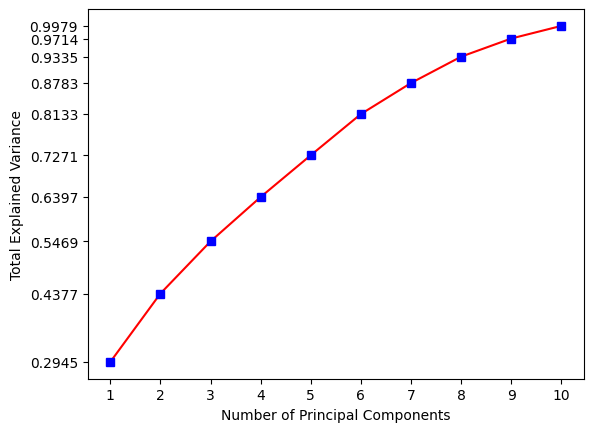

In [84]:
# Original code from Dangeti (2017)
# Adapted by Andres Tarazona
# Choosing the number of Principal Components
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
max_pc = 11

pcs = []
totexp_var = []


for i in range(1, max_pc):
    pca = PCA(n_components=i)
    pca.fit(X_train)
    pcs.append(i)
    totexp_var.append(pca.explained_variance_ratio_.sum())

plt.plot(pcs, totexp_var, 'r')
plt.plot(pcs, totexp_var, 'bs')
plt.xlabel('Number of Principal Components')
plt.ylabel('Total Explained Variance')

plt.xticks(pcs)
plt.yticks(totexp_var)
plt.show()

According with Dangeti (2017), there are 2 methods to select the correct amount of Principal Components:
- Method 1: Select the Number of PCs based on diminishing marginal improvement in variance explained.
- Method 2: Select the Number of PCs based on total variance explained greater than 80%.

From the plot above, we can see that total variance explained greater than 80% is achieved at 6 PCs. The method 1 is not considered since there is an a similar improvement between PCs along all the possible PCs.

In [85]:
import matplotlib.pyplot as plt

n_components = 6

# Perform PCA with n components
pca = PCA(n_components=n_components)
X_train_pca = pca.fit_transform(X_train)
X_test_pca = pca.transform(X_test)

# Add constnat for OLS
X_train_pca_new = sm.add_constant(X_train_pca)
X_test_pca_new = sm.add_constant(X_test_pca)

model = sm.OLS(y_train,X_train_pca_new).fit()
print(model.summary())

# Make predictions on the test data
y_pred = model.predict(X_test_pca_new)

# Calculate the mean squared error and R-squared
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
mae = mean_absolute_error(y_test,y_pred)
y_avg = y.mean()
print("y average:", y_avg)
print("MSE:",mse)
print("SQRT MSE:", np.sqrt(mse))
print("MAE:",mae)

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.180
Model:                            OLS   Adj. R-squared:                  0.179
Method:                 Least Squares   F-statistic:                     125.3
Date:                Sat, 04 Nov 2023   Prob (F-statistic):          1.34e-143
Time:                        22:21:36   Log-Likelihood:                -4108.8
No. Observations:                3428   AIC:                             8232.
Df Residuals:                    3421   BIC:                             8275.
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          5.8781      0.014    428.552      0.0

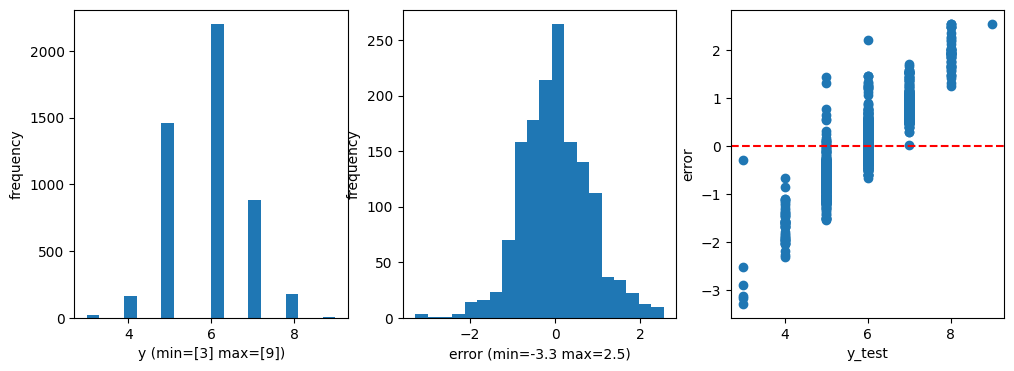

In [86]:
error = y_test.ravel()-y_pred.ravel()
fig, axes = plt.subplots(1, 3,figsize=(12,4))

plt.subplot(1,3,1)
plt.hist(y,bins=20)
plt.xlabel(f"y (min={min(y)} max={max(y)})")
plt.ylabel("frequency")

plt.subplot(1,3,2)
plt.hist(error,bins=20)
plt.xlabel(f"error (min={min(error):.2} max={max(error):.2})")
plt.ylabel("frequency")

plt.subplot(1,3,3)
plt.scatter(y_test.ravel(),error)
plt.xlabel("y_test")
plt.ylabel("error")
plt.axhline(y = 0.0, color = 'r', linestyle = 'dashed') 

plt.show()

## Applying transformation to independent variables

In [87]:
# Make a copy of the existing dataset
wine_quality_modified = wine_quality.copy()

# Apply data transformation to correct skewness
wine_quality_modified['fixed_acidity'] = np.log(wine_quality_modified['fixed_acidity'])
wine_quality_modified['volatile_acidity'] = np.cbrt(wine_quality_modified['volatile_acidity'])
wine_quality_modified['citric_acid'] = np.sqrt(wine_quality_modified['citric_acid'])
wine_quality_modified['residual_sugar'] = np.cbrt(wine_quality_modified['residual_sugar'])
wine_quality_modified['chlorides'] = np.cbrt(wine_quality_modified['chlorides'])
wine_quality_modified['free_sulfur_dioxide'] = np.log(wine_quality_modified['free_sulfur_dioxide'])
wine_quality_modified['total_sulfur_dioxide'] = np.sqrt(wine_quality_modified['total_sulfur_dioxide'])
#wine_quality_modified.drop(columns=['density'], inplace=True) # Drop columns since data correction was not found. Also it displays high correlation with other two variables
wine_quality_modified['pH'] = 1/np.sqrt(wine_quality_modified['pH'])
wine_quality_modified['sulphates'] = 1/np.cbrt(wine_quality_modified['sulphates'])
wine_quality_modified['alcohol'] = 1/(wine_quality_modified['alcohol'])

In [88]:
# Remember density was removed from the data
features = ['fixed_acidity', 
            'volatile_acidity', 
            'citric_acid', 
            'residual_sugar',
            'chlorides', 
            'free_sulfur_dioxide', 
            'total_sulfur_dioxide',
            'density',
            'pH', 
            'sulphates', 
            'alcohol']

X = wine_quality_modified.loc[:, features].values

y = wine_quality_modified.loc[:, ['quality']].values

X = StandardScaler().fit_transform(X)

Split the dataset

In [89]:
# Split the dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y, random_state=42)

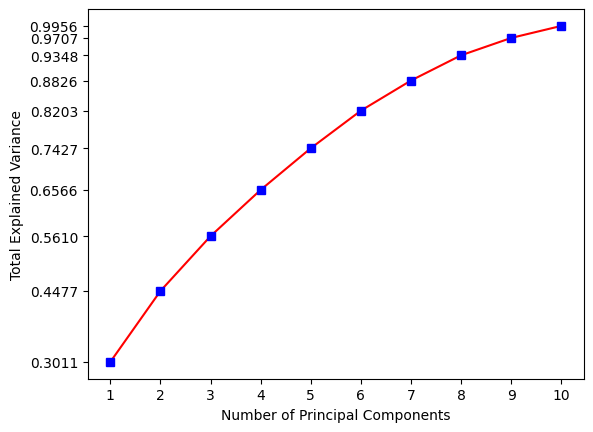

In [90]:
# Original code from Dangeti (2017)
# Adapted by Andres Tarazona
# Choosing the number of Principal Components
max_pc = 11

pcs = []
totexp_var = []


for i in range(1, max_pc):
    pca = PCA(n_components=i)
    pca.fit(X_train)
    pcs.append(i)
    totexp_var.append(pca.explained_variance_ratio_.sum())

plt.plot(pcs, totexp_var, 'r')
plt.plot(pcs, totexp_var, 'bs')
plt.xlabel('Number of Principal Components')
plt.ylabel('Total Explained Variance')

plt.xticks(pcs)
plt.yticks(totexp_var)
plt.show()

It is possible to achieve better explainability by using the same amount of PCs. By using 6 Principal Components, it is possible to explain 82,03% of the data.

In [91]:
n_components = 6

# Perform PCA with n components
pca = PCA(n_components=n_components)
X_train_pca = pca.fit_transform(X_train)
X_test_pca = pca.transform(X_test)

# Add constnat for OLS
X_train_pca_new = sm.add_constant(X_train_pca)
X_test_pca_new = sm.add_constant(X_test_pca)

model = sm.OLS(y_train,X_train_pca_new).fit()
print(model.summary())

# Make predictions on the test data
y_pred = model.predict(X_test_pca_new)

# Calculate the mean squared error and R-squared
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
mae = mean_absolute_error(y_test,y_pred)
y_avg = y.mean()
print("y average:", y_avg)
print("MSE:",mse)
print("SQRT MSE:", np.sqrt(mse))
print("MAE:",mae)

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.219
Model:                            OLS   Adj. R-squared:                  0.217
Method:                 Least Squares   F-statistic:                     159.7
Date:                Sat, 04 Nov 2023   Prob (F-statistic):          2.67e-179
Time:                        22:31:59   Log-Likelihood:                -4026.0
No. Observations:                3428   AIC:                             8066.
Df Residuals:                    3421   BIC:                             8109.
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          5.8781      0.013    439.024      0.0